In [1]:
import pandas as pd
import io

Upload the files given on the virtuale.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving val_data.csv to val_data (1).csv
Saving train_data.csv to train_data (1).csv
Saving test_data.csv to test_data (1).csv


In [3]:
import io
train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('val_data.csv')
test_df = pd.read_csv('test_data.csv')

In [4]:
print(len(train_df))
print(len(val_df))
print(len(test_df))

17348
3718
3717


Let us inspect the data

In [5]:
train_df


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,8573,3,1,2,0,1,Can't get no money from me you silly hoe
1,21898,3,0,3,0,1,That was almost 10 years ago. I gave ALL them ...
2,17409,3,0,3,0,1,"RT @RakwonOGOD: Bitches tweeting ""last night &..."
3,21861,3,0,3,0,1,"That hoe out there, Fat Trel said it best."
4,8532,3,0,0,3,2,Can Charlie Crist pull one over on Rick Scott?...
...,...,...,...,...,...,...,...
17343,9729,6,0,6,0,1,Going hard bitch swear I'm on my job throw a q...
17344,14504,3,0,0,3,2,RT @AmPowerBlog: @velvethammer Parent in Phoen...
17345,20207,3,1,2,0,1,RT @nostalgic_mike: Aw y'all some hoes hating ...
17346,22962,3,0,0,3,2,Watch out #ned! #crc #worldcup2014 #puravida h...


As you see, for sentences there are 7 fields:


*   id: numeric identifies
*   count: number of words relevant for classification (sum of the following three numbers)
*   hate_speech: number of words associted with hate speech
*   offensive_language: number of words associted with offensive language
*   neither: number of words associated with none of the previous classes
*   class: the actual category of the sentence
*   tweet: the sentence









You may just use the class and the tweet, but this is up to you. You are also free to preprocess the sentence as you better like. You can also decide about tokenization and embedding, possibly exploiting pretrained word embeddings.

You CANNOT do data agumgentation.

Please submit a single, well documented notebook.

GOOD WORK!

In [6]:
!pip install tqdm
!pip install transformers
!pip install torch

# Preprocessing
Data cleaning of URL, hastag, mentions, emoji and non-alphanumerical text

In [7]:
import re

def clean(text):
  #set text lowercase
  text = str(text).lower()

  #remove URL https
  text = re.sub('https?://\S+', '', text)
  #remove mentions
  text = re.sub(r'@\w+', '', text)
  #remove "retweet" abbreviation
  text = re.sub('rt', '', text)
  #remove '>'
  text = re.sub(r'&gt;', '', text)
  #remove '<'
  text = re.sub(r'&lt;', '', text)
  #remove http from URL
  text = re.sub('http', '', text)
  #remove @ mentions, # hashtag and non-alphanumeric char except !?',.() which I consider important for the training
  text = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t!?',.()])|(\w+:\/\/\S+)","",text)

  return text

#data preprocessing in all dataframe
train_df["tweet"] = train_df["tweet"].apply(clean)
val_df["tweet"] = val_df["tweet"].apply(clean)
test_df["tweet"] = test_df["tweet"].apply(clean)

In [8]:
#example of function clean
text= 'RT @_theDarius: &#8220;@JetsAndASwisher: @_theDarius boy I was clean in them bitches.&#8221;you loved them damn sandals &#128514;'
clean(text)

'    boy i was clean in them bitches.you loved them damn sandals '

Plotting class distribution

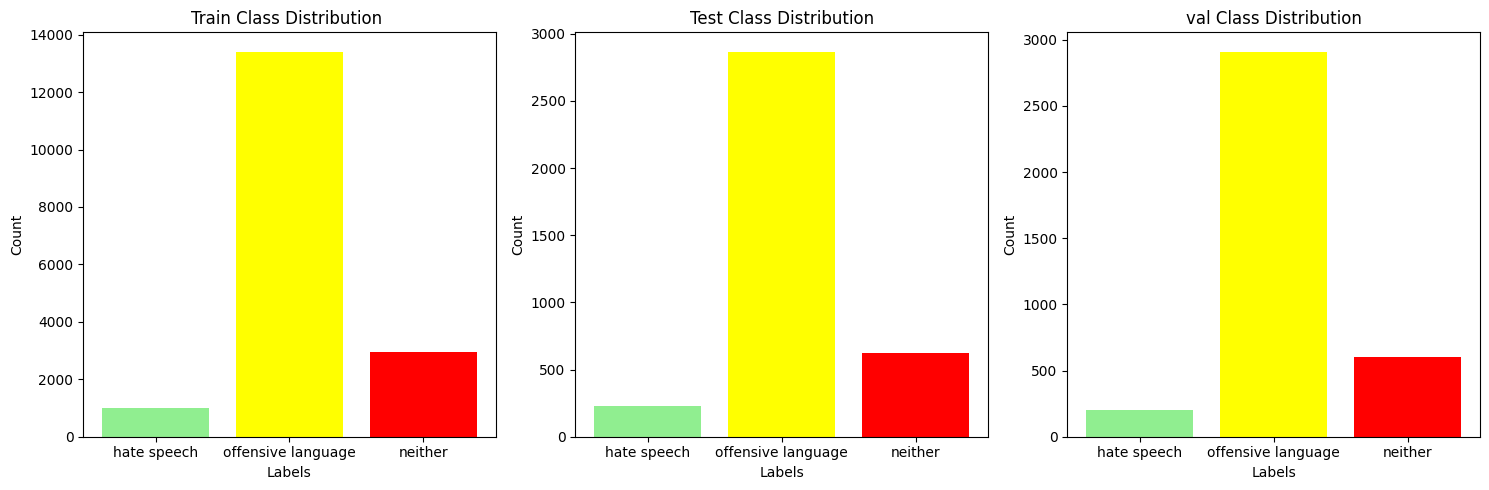

In [9]:
import matplotlib.pyplot as plt

# function to plot all class distribution
def plot_label(ax, df, title):
    label_counts = df['class'].value_counts()
    labels = ['hate speech', 'offensive language', 'neither']
    counts = [label_counts[0], label_counts[1], label_counts[2]]
    colors = ["lightgreen", "yellow", "red"]

    ax.bar(labels, counts, color=colors)
    ax.set_xlabel("Labels")
    ax.set_ylabel("Count")
    ax.set_title(title)

# Set up figure with subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot train_df
plot_label(axs[0], train_df, "Train Class Distribution ")

# Plot test_df
plot_label(axs[1], test_df, "Test Class Distribution")

# Plot val_df
plot_label(axs[2], val_df, "val Class Distribution")

plt.tight_layout()
plt.show()


# DistilBert

I chose to use Bert model because it is one of the models that has managed to reach the state-of-the-art in this NLP related task.
As the acronym suggests is a Bidirectional Encoder Representations from Transformers and it is an open source machine learning framework.



*   Bidirectional: Bidirection is really useful in NLP because it is possibile to understand the context and meaning of the token word
*   Transformer-based architecture: A transformer-based architecture enable it  to effectively capture extensive contextual relationships and dependencies among words
* Embedding: It's used to process word into numerical vectors which lead the model to work with it given the context.
* Tokenization: Split text in single words

DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base.







---



In order to pass the data into DistilBert Model, I need to tokenized my dataframe and prepare attention mask + tensors.
Bert's model need tokenized text and attention mask as input, plus i need to pass tensors which are ground truth for classification.

In [28]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification,DistilBertForSequenceClassification,AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split


Set the tokenizer in order to obtain max_length of sequences

In [29]:
from transformers import DistilBertTokenizer, BertForSequenceClassification,DistilBertForSequenceClassification,AdamW
tokenizer = DistilBertTokenizer.from_pretrained("bert-base-uncased")

#calculation of max_lenght in the tokenized tweet dataframe
lenght = [len(tokenizer.tokenize(tweet)) for tweet in train_df['tweet'].tolist()]
max_lenght = max(lenght)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


Tokenization of the 3 dataset: train,test and val

In [13]:
import pandas as pd
from transformers import DistilBertTokenizer, BertForSequenceClassification,DistilBertForSequenceClassification,AdamW

#tokenization of all the dataframe

#preparing tokenizer based on DistilBert in order to tokenize text into integer sequences, useful for the model to understand data
tokenizer = DistilBertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(data):
    #I choose to mantain padding and truncation in order to get uniform lenght
    inputs = tokenizer(data['tweet'].tolist(), padding=True, truncation=True, return_tensors="pt", max_length=max_lenght)

    #convert class value in pytorch tensor
    labels = torch.tensor(data['class'].tolist())

    #return combined [input_ids(tokenized tweet), attention_mask(value to consider or ignore) and tensor] compacted together
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)


train_dataset = tokenize_data(train_df)
val_dataset = tokenize_data(val_df)
test_dataset = tokenize_data(test_df)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


Setting up device in order to run it in gpu

In [14]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [15]:
class_labels = train_df['class'].values
print(type(class_labels))

<class 'numpy.ndarray'>


Calculating class weights to balance the model

In [30]:
import numpy as np
class_values = train_df['class'].values

#class weight based on their distribution
classes, num_classes = np.unique(class_values, return_counts=True) #classes=unique values --- num_classes=number of classes
total_samples = len(class_values)

# Calculate class weights
class_weights = total_samples / (len(classes) * num_classes)

class_weights = [class_weights[0], class_weights[1], class_weights[2]]
print(class_weights)

[5.794255177020708, 0.43115617854657523, 1.9682323576128886]


# Training

Training DistilBert model using DistilBertForSequenceClassification.

In [20]:
from tqdm import tqdm
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Set up the DistilBERT tokenizer and model for sequence classification
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# since I need a classification based on [0,1,2], i'll set num_labels=3
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

batch_size = 8
#Set up dataloader with batch_size and shuffle to add randomness in training
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Set up class_weights to improve balance in model classification
class_weights = [float(class_weights[0]), float(class_weights[1]), float(class_weights[2])]
#class_weights= [1.0,1.0,1.0]
# Set up AdamW optimizer and learning rate scheduler.
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)


num_epochs = 5
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
# Training
for epoch in range(num_epochs):
    #start training
    model.train()
    total_correct = 0  # correct predictions
    total_samples = 0  # processed samples
    total_loss = 0  # total loss
    # tqdm used for obtain progressing bar of the train_dataloader
    train_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", dynamic_ncols=True)

    # loop on batch in train_iterator
    for batch in train_iterator:
        # shift data in order to use them in gpu
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Retrieve the logits from the outputs
        logits = outputs.logits

        # Calculate the weighted cross-entropy loss
        loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
        loss = loss_fn(logits, labels)

        total_loss += loss.item()

        # Calculate accuracy
        predicted_labels = torch.argmax(logits, dim=1)
        total_correct += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Update the tqdm progress bar with the current loss and accuracy
        train_iterator.set_postfix({"Train Loss": total_loss / len(train_iterator), "Train Acc": total_correct / total_samples})

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = total_correct / total_samples

    # Validation loop.
    model.eval()
    val_loss = 0
    val_correct = 0  # Track total correct predictions
    val_samples = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            # Retrieve the logits from the outputs
            logits = outputs.logits

            # Calculate the weighted cross-entropy loss
            loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
            loss = loss_fn(logits, labels)

            val_loss += loss.item()

            # Calculate accuracy
            predicted_labels = torch.argmax(logits, dim=1)
            val_correct += (predicted_labels == labels).sum().item()
            val_samples += labels.size(0)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = val_correct / val_samples

    # Print train and validation loss and accuracy in each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train loss: {avg_train_loss:.3f}, Train Acc: {train_accuracy:.3f}")
    print(f"Validation loss: {avg_val_loss:.3f}, Validation Acc: {val_accuracy:.3f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5:   0%|          | 0/2169 [00:00<?, ?it/s]

Epoch 1/5
Train loss: 0.692, Train Acc: 0.891
Validation loss: 0.616, Validation Acc: 0.898


Epoch 2/5:   0%|          | 0/2169 [00:00<?, ?it/s]

Epoch 2/5
Train loss: 0.570, Train Acc: 0.915
Validation loss: 0.654, Validation Acc: 0.906


Epoch 3/5:   0%|          | 0/2169 [00:00<?, ?it/s]

Epoch 3/5
Train loss: 0.514, Train Acc: 0.926
Validation loss: 0.629, Validation Acc: 0.906


Epoch 4/5:   0%|          | 0/2169 [00:00<?, ?it/s]

Epoch 4/5
Train loss: 0.481, Train Acc: 0.932
Validation loss: 0.629, Validation Acc: 0.906


Epoch 5/5:   0%|          | 0/2169 [00:00<?, ?it/s]

Epoch 5/5
Train loss: 0.485, Train Acc: 0.932
Validation loss: 0.629, Validation Acc: 0.906


Model Shape

In [21]:
#Model architecture
state_dict = model.state_dict()

for key, value in state_dict.items():
    print(f"Layer name: {key}, Shape: {value.shape}")

Layer name: distilbert.embeddings.word_embeddings.weight, Shape: torch.Size([30522, 768])
Layer name: distilbert.embeddings.position_embeddings.weight, Shape: torch.Size([512, 768])
Layer name: distilbert.embeddings.LayerNorm.weight, Shape: torch.Size([768])
Layer name: distilbert.embeddings.LayerNorm.bias, Shape: torch.Size([768])
Layer name: distilbert.transformer.layer.0.attention.q_lin.weight, Shape: torch.Size([768, 768])
Layer name: distilbert.transformer.layer.0.attention.q_lin.bias, Shape: torch.Size([768])
Layer name: distilbert.transformer.layer.0.attention.k_lin.weight, Shape: torch.Size([768, 768])
Layer name: distilbert.transformer.layer.0.attention.k_lin.bias, Shape: torch.Size([768])
Layer name: distilbert.transformer.layer.0.attention.v_lin.weight, Shape: torch.Size([768, 768])
Layer name: distilbert.transformer.layer.0.attention.v_lin.bias, Shape: torch.Size([768])
Layer name: distilbert.transformer.layer.0.attention.out_lin.weight, Shape: torch.Size([768, 768])
Layer 

Saving trained model

In [22]:
#saving model
model.save_pretrained('/content/model')


# Testing

Testing the model on tokenized test dataset

In [26]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from tqdm.auto import tqdm
import torch
import pandas as pd

# Load Model
model = DistilBertForSequenceClassification.from_pretrained('/content/model')

# Set up tokenizer based on DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("bert-base-uncased")

# Shift device to GPU if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Sequence of predictions
y_pred = []

# Create a tqdm progress bar for the test data
test_iterator = tqdm(test_df['tweet'], desc="Prediction", dynamic_ncols=True)

for text in test_iterator:
    # Tokenization and setting up the variable in device
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # model prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # predicted class sequences
    logits = outputs.logits
    predicted_class = torch.argmax(logits, 1).item()

    y_pred.append(predicted_class)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


Prediction:   0%|          | 0/3717 [00:00<?, ?it/s]

# Evaluation

Using F1-score in order to evaluate the performance combining precision and recall

In [27]:
from sklearn.metrics import f1_score

y = test_df['class']
y_pred = y_pred
macro_f1 = f1_score(y, y_pred, average='macro')

print(f"Macro F1-score: {macro_f1:.4f}")

f1_scores = f1_score(y, y_pred, average=None)

print("F1-Scores for Each Class:", f1_scores)

Macro F1-score: 0.7749
F1-Scores for Each Class: [0.48598131 0.94716585 0.89147287]


In [25]:
import torch

# Move model in device
model.to(device)
labels = ['hate speech', 'offensive language', 'neither']
# Text to predict
text = "i'm so happy today"

# tokenization
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

# Move data in same model device
inputs = {key: value.to(device) for key, value in inputs.items()}

# Prediction
with torch.no_grad():
    outputs = model(**inputs)

# Get class label from the output
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

print("Predicted Label:", labels[predicted_class])


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted Label: neither


# Conclusion
Although the f1-score of the label 0 is low, it was the maximum that I was able to evaluate because of the imbalance of the classes in the dataset and the impossibility in the use data augmentation. I did undersampling tests but it reached overfitting and the accuracy of train and val were worse than the current ones